In [1]:
import torch.utils.data as data
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
class ToyDataset(data.Dataset):
    def __init__(self):
        super(ToyDataset, self).__init__()
        self.X = torch.randint(low=0, high=7, size=(1000, 10))
        self.y = (self.X == 0).sum(dim=1)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
data_train = ToyDataset()
data_test = ToyDataset()
loader_train = data.DataLoader(data_train, batch_size=32, shuffle=True, pin_memory=True)
loader_test = data.DataLoader(data_test, batch_size=32, shuffle=False, pin_memory=True)

In [5]:
for X, y in loader_train:
    print(X.shape, y.shape)
    print(X[0, :], y[0])
    break

torch.Size([32, 10]) torch.Size([32])
tensor([2, 0, 2, 2, 3, 3, 4, 2, 0, 3]) tensor(2)


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.eb = nn.Embedding(7, 16)
        self.lstm = nn.LSTM(16, 16, 2, batch_first=True, dropout = 0.1, bidirectional=True)
        self.fc = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.eb(x)      # torch.Size([32, 10, 16])
        x, _ = self.lstm(x) # torch.Size([32, 10, 32])
        x = x.mean(dim=1)   # torch.Size([32, 32])
        x = self.fc(x).view(-1) # torch.Size([32])
        return x

In [7]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()

In [8]:
loss_train = []
acc_test = []

for epoch in range(20):
    print(epoch)
    losses = []
    correct, total = 0, 0
    
    for X, y in loader_train:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        loss = criterion(y, pred)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        for X, y in loader_test:
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                pred = net(X)
                pred = torch.round(pred).long()
                correct += (pred == y).sum().item()
                total += y.size(0)
    
    acc_test.append(correct / total)
    loss_train.append(np.array(losses).mean())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


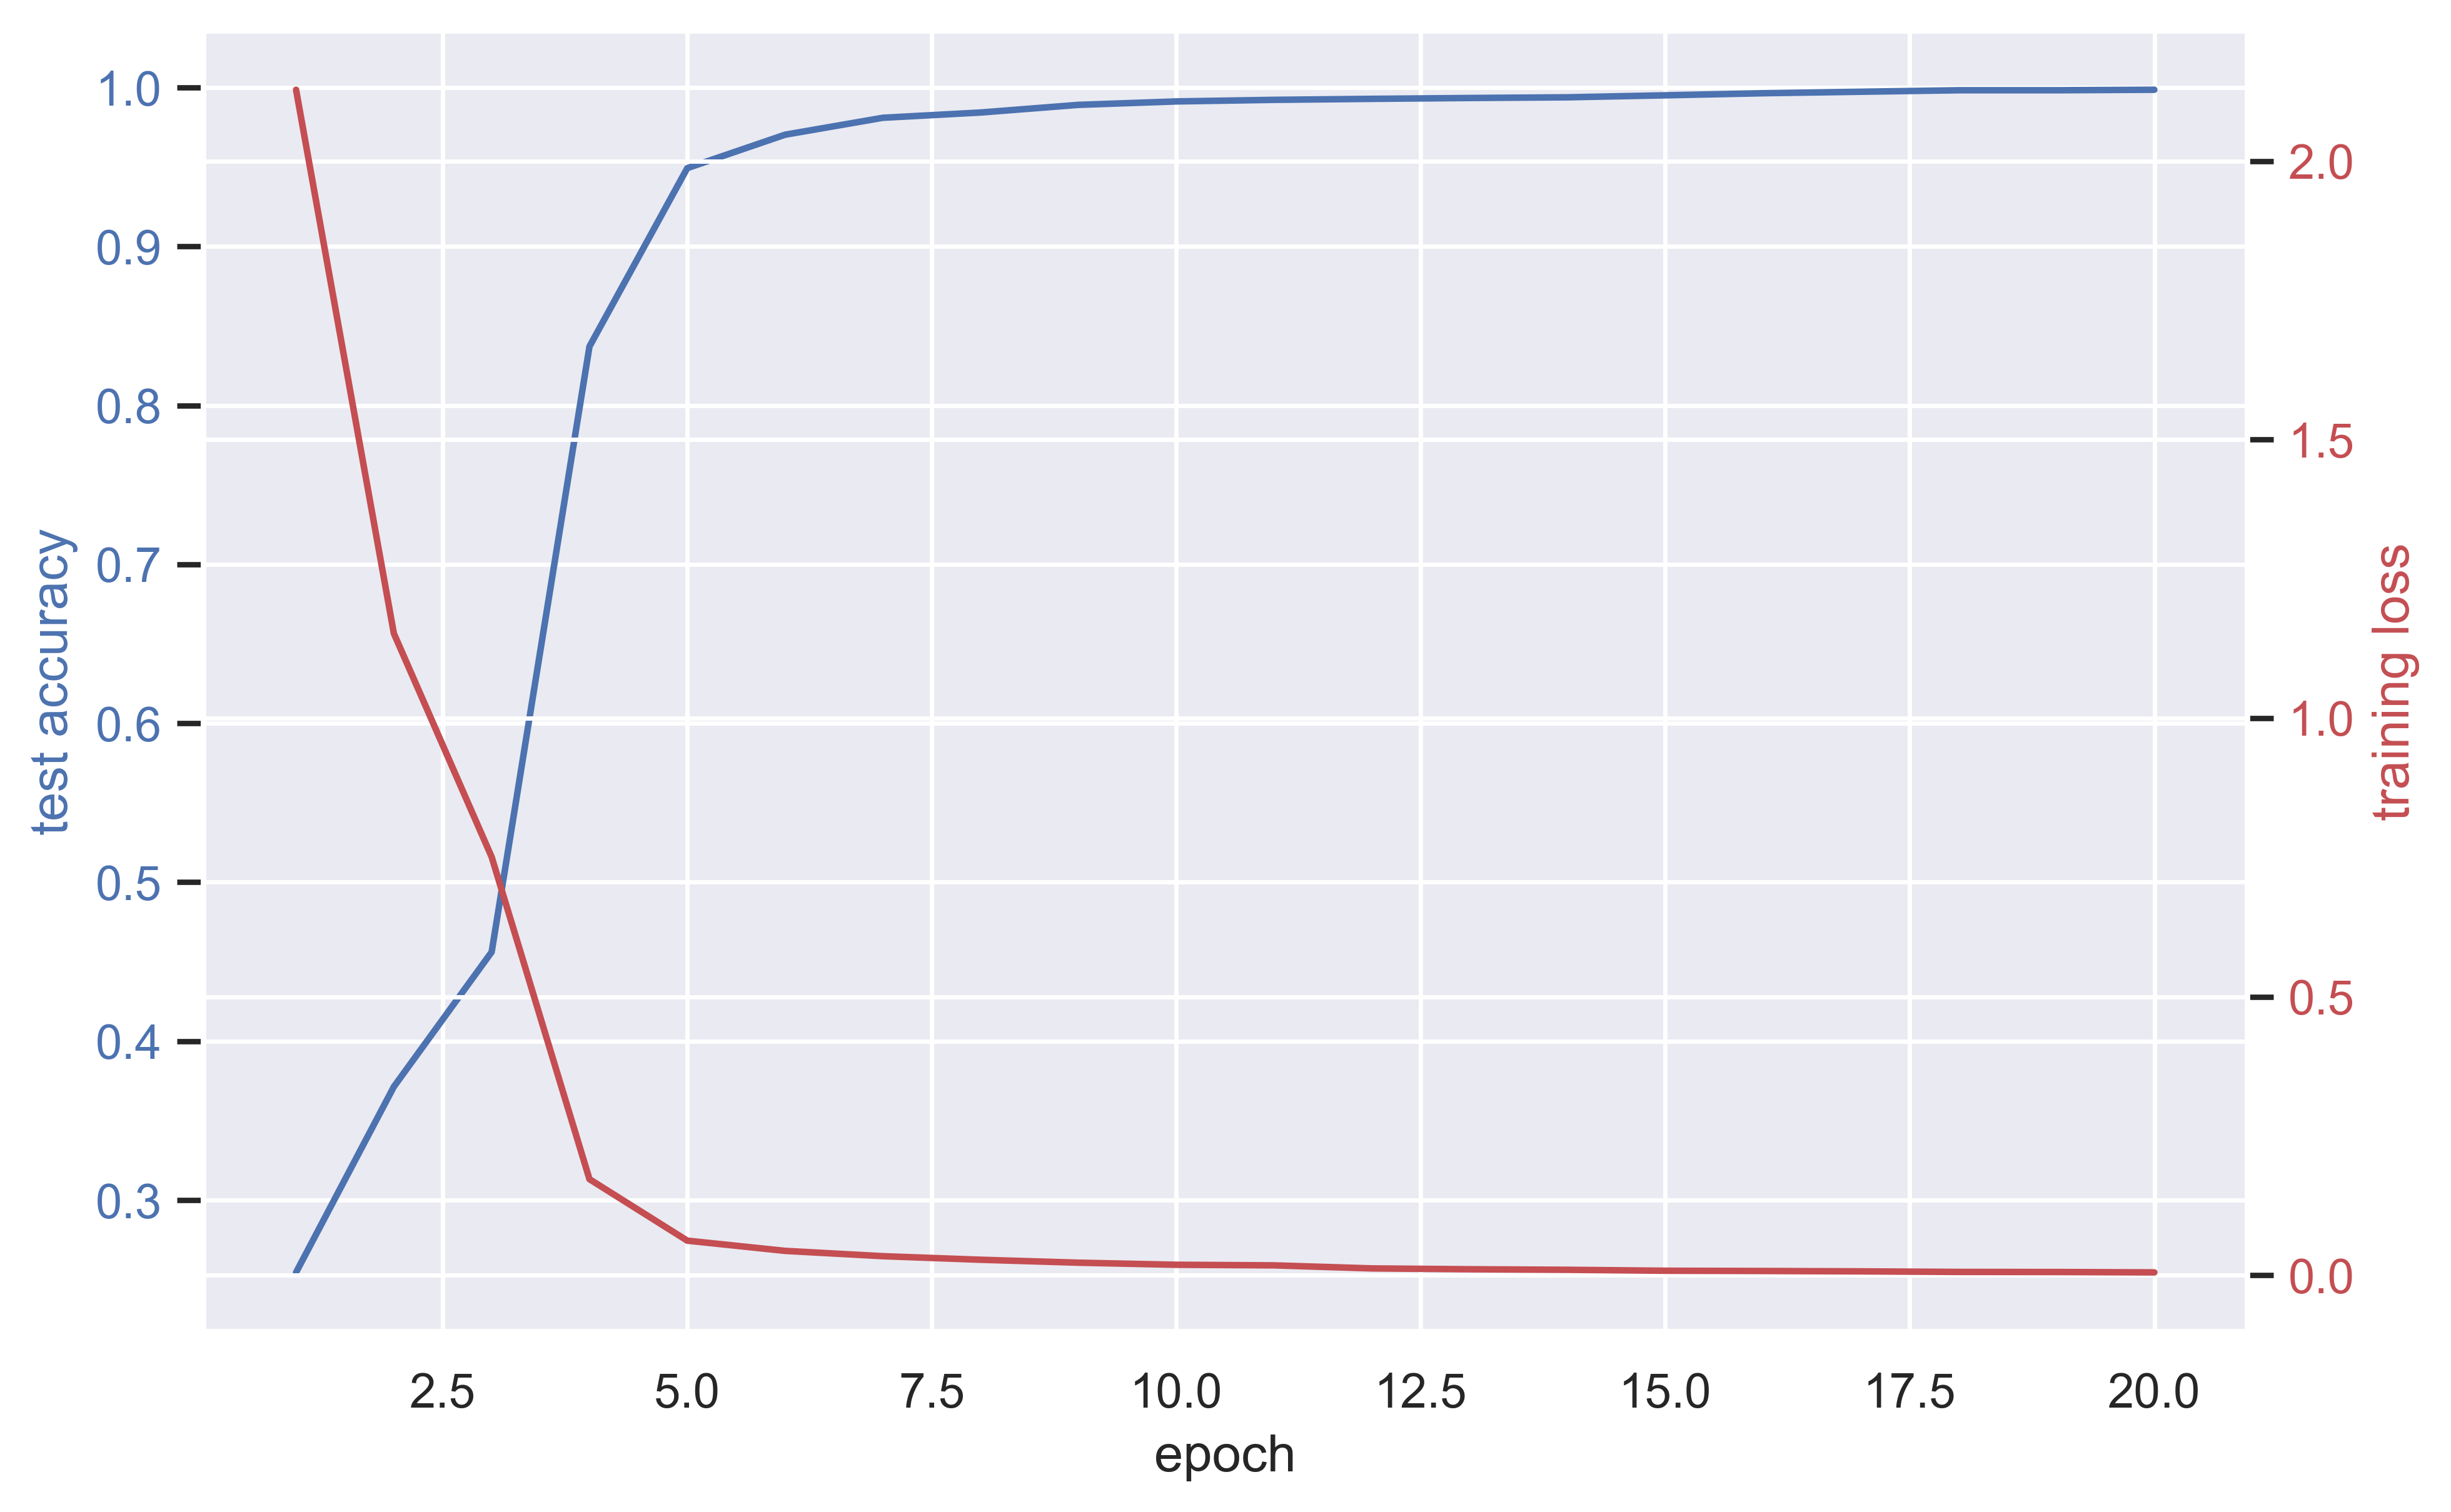

In [9]:
epochs = range(1, len(loss_train) + 1)

fig, ax1 = plt.subplots(figsize=(8, 5), dpi=500)

color = 'b'
ax1.set_ylabel('test accuracy', color=color)
ax1.set_xlabel('epoch')
ax1.plot(epochs, acc_test, color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'r'

ax2.set_ylabel('training loss', color=color)
ax2.plot(epochs, loss_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# saving the model

In [10]:
torch.save(net.state_dict(), 'model.pt')

model = Net()
model.load_state_dict(torch.load('model.pt'))
model.eval()

correct, total = 0, 0
for X, y in loader_test:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = torch.round(pred).long()
    correct += (pred == y).sum().item()
    total += y.size(0)
print(correct / total)

0.999
